# Question 1

Develop a feed forward neural network in python that classifies the images found in the MNIST dataset. You are to train your neural network using backpropagation. You must show that you have:

- Performed K-fold cross correlation.
- Used weight decay for regularization.
- Investigated the performance of your neural network for different (a) numbers of hidden layers and (b) size of - hidden layers.

In [12]:
%matplotlib inline

import numpy as np
from lib.Network import Network, sigmoid
from lib.util import *
# This is a simple example with one layer, it's not sufficient
# Just to kind of get started
with(open('config.json', 'r')) as f:
    config = json.load(f)

train_filename_gz = maybe_download(config['train']['images'], 9912422)
test_filename_gz = maybe_download(config['test']['images'], 1648877)
train_labels_gz = maybe_download(config['train']['labels'], 28881)
test_labels_gz = maybe_download(config['test']['labels'], 4542)

train_pickle = extract(train_filename_gz)
train_labels_pickle = extract(train_labels_gz)
test_pickle = extract(test_filename_gz)
test_labels_pickle = extract(test_labels_gz)

train_data = load_pickle(train_pickle)
train_labels = load_pickle(train_labels_pickle)
test_data = load_pickle(test_pickle)
test_labels = load_pickle(test_labels_pickle)

# There are now 60,000 items of length 784 (28x28)
# This will serve as input to neural network
# Each cell will have 784 inputs
input_training = train_data.reshape(60000, 784)

Found and verified .cache\train-images-idx3-ubyte.gz
Found and verified .cache\t10k-images-idx3-ubyte.gz
Found and verified .cache\train-labels-idx1-ubyte.gz
Found and verified .cache\t10k-labels-idx1-ubyte.gz
Performing pickle.load(.cache\train-images-idx3-ubyte.pickle)
Performing pickle.load(.cache\train-labels-idx1-ubyte.pickle)
Performing pickle.load(.cache\t10k-images-idx3-ubyte.pickle)
Performing pickle.load(.cache\t10k-labels-idx1-ubyte.pickle)


We will experiment with different Neural Network configurations to try and maximize accuracy. I've put together a couple configurations that I will include in the `.cache` directory - accessible through `interactive-brain.py`.

In [13]:
configurations = [
    {
        "learning_rate": 0.25,
        "tolerance": 0.01,
        "max_iter": 100,
        "layers": [784, 20, 10]
    },
    {
        "learning_rate": 0.25,
        "tolerance": 0.01,
        "max_iter": 100,
        "layers": [784, 30, 15, 10]
    }
]

In [14]:
for config in configurations:
    net = Network(learning_rate=config['learning_rate'], tolerance=config['tolerance'], max_iter=config['max_iter'])
    
    for layer in config['layers']:
        net.add_layer(layer, sigmoid)

For the purpose of the document, I've already cached a couple brains for testing.

I'll display some information regarding each system, and then use weight decay regularization to compare them (essentially adding a bias term to the measured network error.

In [15]:
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def accuracy(net):
    plot = {
        "Accuracy": net.accuracy_list,
        "Confidence_Interval min": [net.confidence_interval[0]] * len(net.accuracy_list),
        "Confidence_Interval max": [net.confidence_interval[1]] * len(net.accuracy_list),
    }
    fig, ax = plt.subplots()
    errors = pd.DataFrame(plot)
    errors.plot(ax=ax)
    plt.title(BRAIN)

    plt.show()

Here we will test our first network configuration.

Inspecting .cache/brain--learning_rate=0.25&tol=0.01&max_iter=100&n_splits=10&layers=784-20-10.pickle
Mean accuracy: 0.842
Confidence Interval: (0.7299107498463836, 0.95408925015361634)


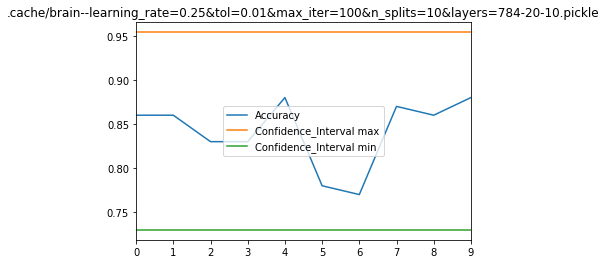

In [16]:
BRAIN = '.cache/brain--learning_rate=0.25&tol=0.01&max_iter=100&n_splits=10&layers=784-20-10.pickle'

net = pickle.load(open(BRAIN, 'rb'))

print 'Inspecting %s' % BRAIN
print 'Mean accuracy:', net.mean_accuracy
print 'Confidence Interval:', net.confidence_interval

accuracy(net)

The system we just computed has only one hidden layer with 20 hidden units.

We'll now experiment with a network configuration with two hidden layers, with **30, and 15 hidden units**.

Inspecting .cache/brain--learning_rate=0.25&tol=0.01&max_iter=100&n_splits=10&layers=784-30-15-10.pickle
Mean accuracy: 0.832
Confidence Interval: (0.73359268319885973, 0.93040731680114042)


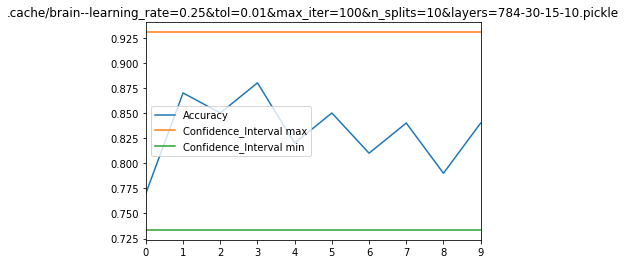

In [17]:
BRAIN = '.cache/brain--learning_rate=0.25&tol=0.01&max_iter=100&n_splits=10&layers=784-30-15-10.pickle'

net = pickle.load(open(BRAIN, 'rb'))

print 'Inspecting %s' % BRAIN
print 'Mean accuracy:', net.mean_accuracy
print 'Confidence Interval:', net.confidence_interval

accuracy(net)

The two *brains* here that have been computed are just cached instances of the neural network being trained. The system trains pretty slow, so I thought I'd include them for convenience sake. They can be found in the `.cache` folder. Their configuration is described in the filename.

<center>
    Now that we have two systems, with same params but different configurations, we can compare them to see which one is better.

    With weight decay regularization, we can determine what system is preferred. We choose a $\lambda{}$, such that the effect of $w^{T}w$, as a bias, doesn't completely overwrite the measure of $MSE_{final}$
</center>


$$E[w] = MSE_{final} + \lambda{} w^{T}w$$
    
<br/>
<center>
    First thing to consider is how to choose a proper $\lambda{}$.
    We'll find a lambda term that affects the result by 10%.
</center>

$$\begin{align}
    \frac{MSE_{final}}{\lambda{}w^{T}w} &> 10 \\
    \frac{MSE_{final}}{10 \cdot w^{T}w} &> \lambda{}
\end{align}$$
<br/>
<center>Using MSE for the first system (784-20-10) to calculate the lambda.</center>

In [18]:
def flatten_weights(net):
    ws = []
    for layer in net.layers[1:]:
        for cell in layer.cells:
            for weight in cell.weights:
                ws.append(weight)
    return np.array(ws)

In [20]:
n1 = '.cache/brain--learning_rate=0.25&tol=0.01&max_iter=100&n_splits=10&layers=784-20-10.pickle'
n2 = '.cache/brain--learning_rate=0.25&tol=0.01&max_iter=100&n_splits=10&layers=784-30-15-10.pickle'

net_1 = pickle.load(open(n1, 'rb'))
net_2 = pickle.load(open(n2, 'rb'))

w = flatten_weights(net_1)

wTw = np.dot(w.T, w)

_lambda = net_1.mean_accuracy / (10 * wTw)

print 'Lambda is ', _lambda

E_n1 = net_1.mean_accuracy + _lambda * wTw

w = flatten_weights(net_2)

wTw = np.dot(w.T, w)

E_n2 = net_2.mean_accuracy + _lambda * wTw

print 'net_1_error', E_n1
print 'net_2_error', E_n2

Lambda is  4.21940312617e-05
net_1_error 0.9262
net_2_error 0.951035756856


Since our goal here is to minimize error, it becomes clear that network 1 performs better (as `net_1_error < net_2_error`), when accounting for weight decay.

As for the training itself, this can be seen in `./a2-q1.py`.